<a href="https://colab.research.google.com/github/AleynaKapusuz/NameEntityRecognation/blob/main/NAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
import tensorflow.keras.layers as k1


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/ColabNotebooks/DogalDilİsleme/

/content/drive/My Drive/ColabNotebooks/DogalDilİsleme


#Reading the csv file

In [ ]:
df = pd.read_csv('ner_dataset.xls', encoding = "ISO-8859-1")

In [ ]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048565,1048575,1048575
unique,47959,35177,42,17
top,Sentence: 47959,the,NN,O
freq,1,52573,145807,887908


# Displaying the unique Tags

In [ ]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [ ]:
#Checking null values, if any.
df.isnull().sum()

,0
Sentence #,1000616
Word,10
POS,0
Tag,0


In [ ]:
df = df.fillna(method = 'ffill')

# Found the Word-POS-Tag

In [ ]:
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]

    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [ ]:
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [ ]:
sentences = getter.sentences

#Let's input the hyperparameters

In [ ]:
batch_size = 64
epochs = 8
max_len = 75
embedding = 40

In [ ]:
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())

word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
print("British kelimesi indeksle tanımlanır: {}".format(word_to_index["British"]))
print("B-org etiketi şu dizinle tanımlanır: {}".format(tag_to_index["B-org"]))


British kelimesi indeksle tanımlanır: 18
B-org etiketi şu dizinle tanımlanır: 6


In [ ]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [ ]:
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [ ]:
num_tag = df['Tag'].nunique()

y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

# Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
print("Eğitim giriş verilerinin boyutu : ", X_train.shape)
print("Eğitim çıktı verilerinin boyutu : ", np.array(y_train).shape)
print("Giriş verilerinin Test boyutu : ", X_test.shape)
print("Çıkış verilerinin Test boyutu : ", np.array(y_test).shape)

Eğitim giriş verilerinin boyutu :  (40765, 75)
Eğitim çıktı verilerinin boyutu :  (40765, 75, 18)
Giriş verilerinin Test boyutu :  (7194, 75)
Çıkış verilerinin Test boyutu :  (7194, 75, 18)


In [ ]:
# Let's verify the first sentence both before and after the process
print('İlk cümleyi işlemeden önce : \n', ' '.join([w[0] for w in sentences[0]]))
print('İlk cümle işlendikten sonra : \n ', X[0])

İlk cümleyi işlemeden önce : 
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
İlk cümle işlendikten sonra : 
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [ ]:
# The initial label before and after the Tag.
print('İlk cümleyi işlemeden önce : \n', ' '.join([w[2] for w in sentences[0]]))
print('İlk cümle işlendikten sonra : \n ', y[0])

İlk cümleyi işlemeden önce : 
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
İlk cümle işlendikten sonra : 
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


#B-LSTM MODEL

In [ ]:
num_tags = df['Tag'].nunique()
max_len = 75
embedding = 40

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(words) + 2, output_dim=embedding, mask_zero=True)(input_layer)  # input_length parametresi kaldırıldı
bidirectional_layer = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(embedding_layer)
time_distributed_layer = TimeDistributed(Dense(50, activation="relu"))(bidirectional_layer)
output_layer = Dense(18 * 2 * 2, activation="softmax")(time_distributed_layer)
output_layer = Bidirectional(LSTM(18 * 2 * 2, return_sequences=True, activation="tanh"))(output_layer)

model = Model(input_layer, output_layer)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 75, 40)         │      1,407,160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 75)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 75, 100)        │         36,400 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 75, 50)         │          5,050 │ bidirectional[0][0],   │
│ (TimeDistributed)         │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 75, 72)         │          3,672 │ time_distributed[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 75, 144)        │         83,520 │ dense_1[0][0],         │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,535,802 (5.86 MB)

 Trainable params: 1,535,802 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpointer = ModelCheckpoint(filepath='model.keras',
                               verbose=0,
                               mode='auto',
                               save_best_only=True,
                               monitor='val_loss')

In [ ]:
y_train = tf.reshape(y_train, (-1, 75))

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [ ]:
history=model.fit(X_train, np.array(y_train),
                  batch_size=batch_size, epochs=8,
                  validation_split=0.1, callbacks =[checkpointer])


Epoch 1/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - accuracy: 0.9411 - loss: 0.3641 - val_accuracy: 0.9444 - val_loss: 0.2205
Epoch 2/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 1026s 2s/step - accuracy: 0.9444 - loss: 0.2203 - val_accuracy: 0.9444 - val_loss: 0.2206
Epoch 3/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 990s 2s/step - accuracy: 0.9445 - loss: 0.2198 - val_accuracy: 0.9444 - val_loss: 0.2203
Epoch 4/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 1013s 2s/step - accuracy: 0.9444 - loss: 0.2205 - val_accuracy: 0.9444 - val_loss: 0.2203
Epoch 5/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - accuracy: 0.9444 - loss: 0.2193 - val_accuracy: 0.9444 - val_loss: 0.2203
Epoch 6/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 975s 2s/step - accuracy: 0.9444 - loss: 0.2194 - val_accuracy: 0.9444 - val_loss: 0.2202
Epoch 7/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.9445 - loss: 0.2194 - val_accuracy: 0.9444 - val_loss: 0.2203
Epoch 8/8
574/574 ━━━━━━━━━━━━━━━━━━━━ 1039s 2s/step - accuracy: 0.9444 - loss: 0.2194 - val_accuracy

# Let's visualize the results in graphical form.

In [ ]:
history.history.keys()

NameError: name 'history' is not defined

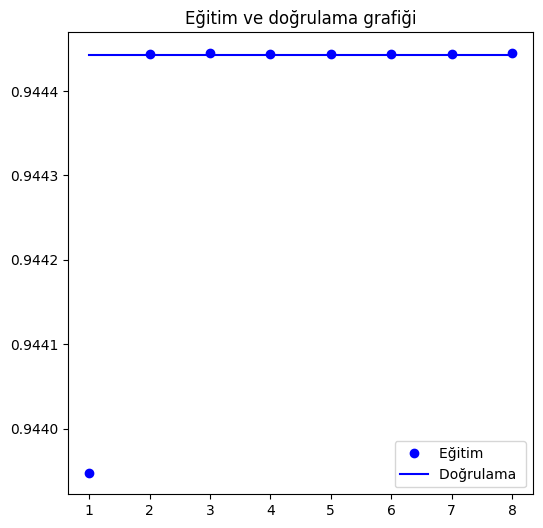

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (6, 6))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Eğitim ')
plt.plot(epochs, val_acc, 'b', label='Doğrulama ')
plt.title('Eğitim ve doğrulama grafiği')
plt.legend()

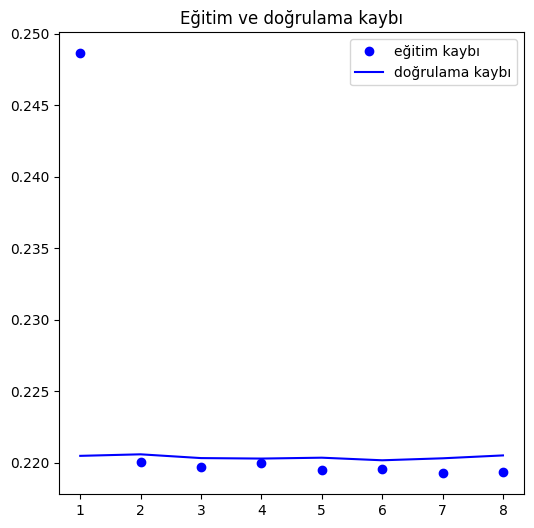

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(epochs, loss, 'bo', label='eğitim kaybı')
plt.plot(epochs, val_loss, 'b', label='doğrulama kaybı')
plt.title('Eğitim ve doğrulama kaybı')
plt.legend()
plt.show()